## 1. MLP+PINN模型泛化性测试，前向差分3平均

Epoch [20/200], Total Loss: 0.01408879, State Loss: 0.00207107, Physics Loss: 1.22100635, Physics Weight: 0.0098
Epoch [40/200], Total Loss: 0.00915145, State Loss: 0.00107972, Physics Loss: 1.27481083, Physics Weight: 0.0063
Epoch [60/200], Total Loss: 0.00715592, State Loss: 0.00067236, Physics Loss: 1.29671190, Physics Weight: 0.0050
Epoch [80/200], Total Loss: 0.00706681, State Loss: 0.00058455, Physics Loss: 1.29645156, Physics Weight: 0.0050
Epoch [100/200], Total Loss: 0.00720492, State Loss: 0.00072599, Physics Loss: 1.29578718, Physics Weight: 0.0050
Epoch [120/200], Total Loss: 0.00693947, State Loss: 0.00045963, Physics Loss: 1.29596875, Physics Weight: 0.0050
Epoch [140/200], Total Loss: 0.00697186, State Loss: 0.00049109, Physics Loss: 1.29615319, Physics Weight: 0.0050
Epoch [160/200], Total Loss: 0.00698374, State Loss: 0.00050691, Physics Loss: 1.29536548, Physics Weight: 0.0050
Epoch [180/200], Total Loss: 0.00692946, State Loss: 0.00045052, Physics Loss: 1.29578831, P

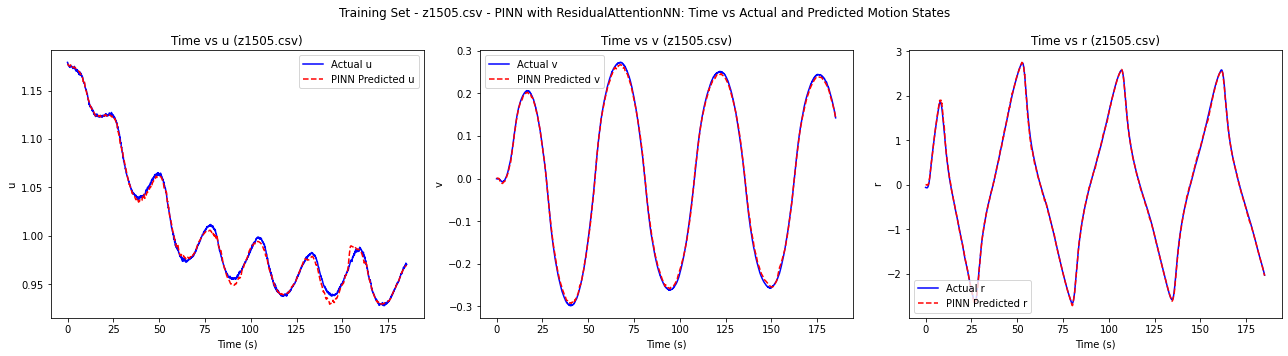

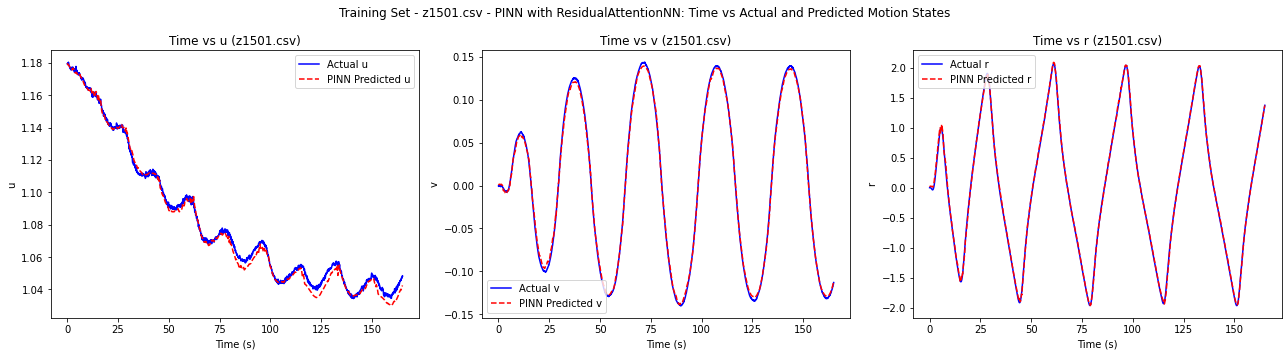

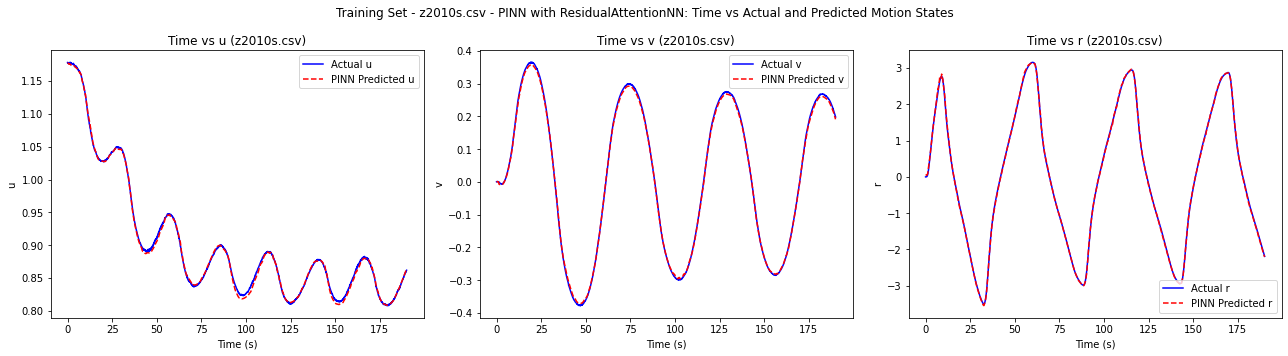

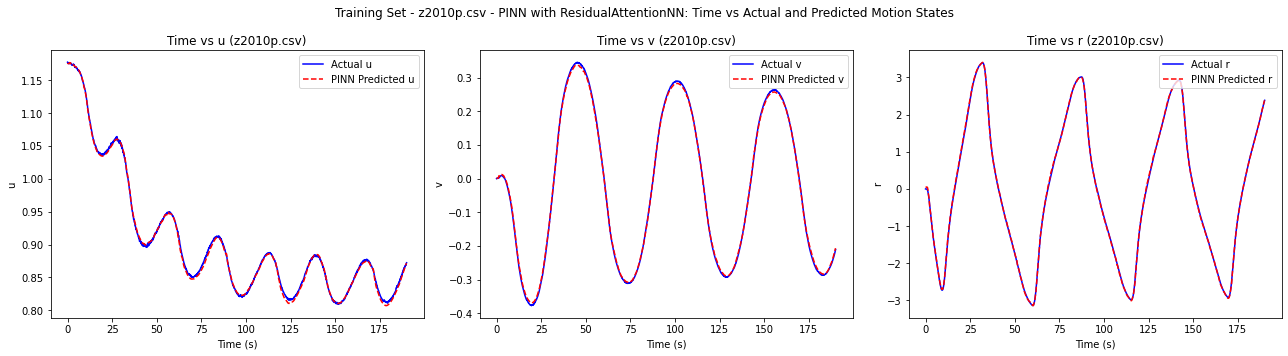

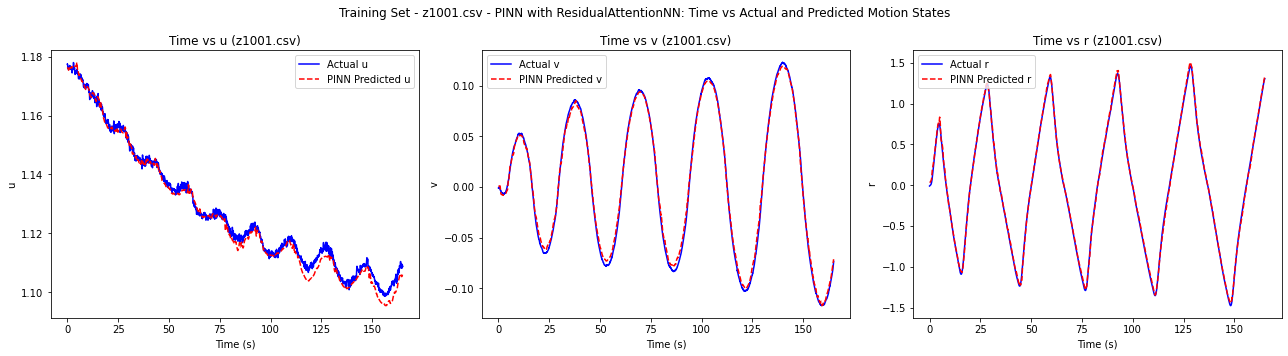

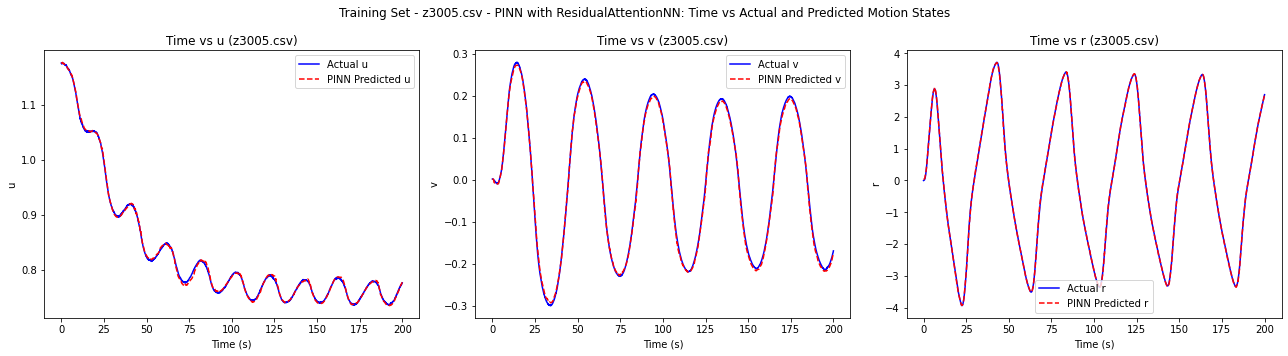

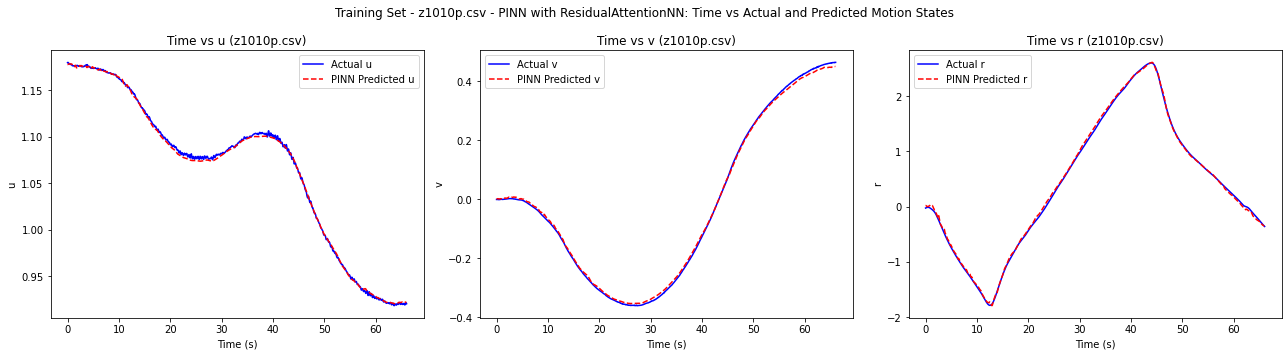

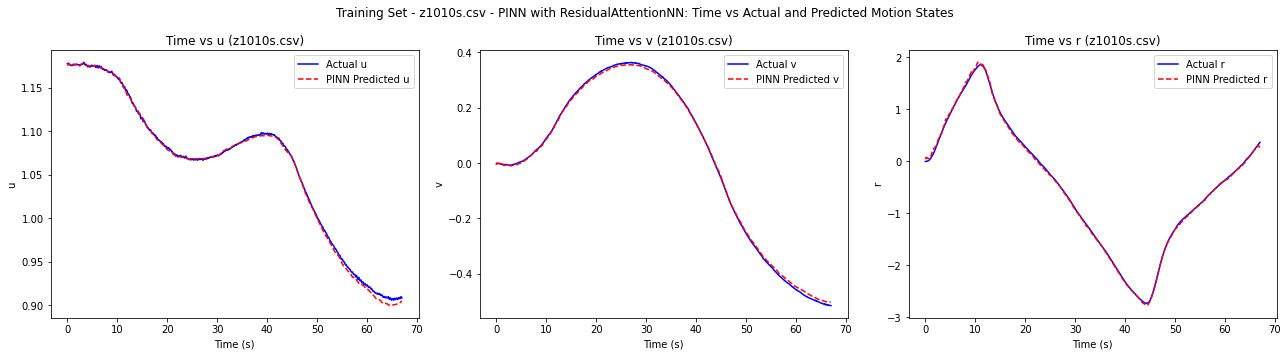

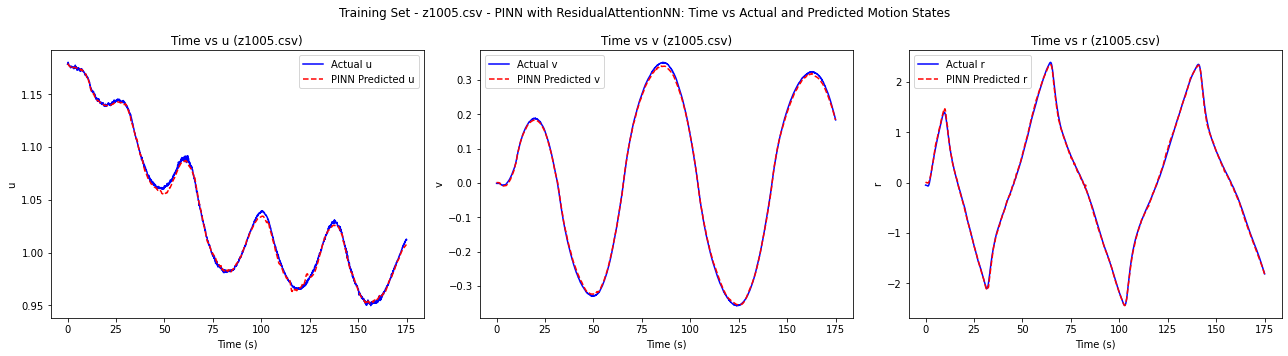

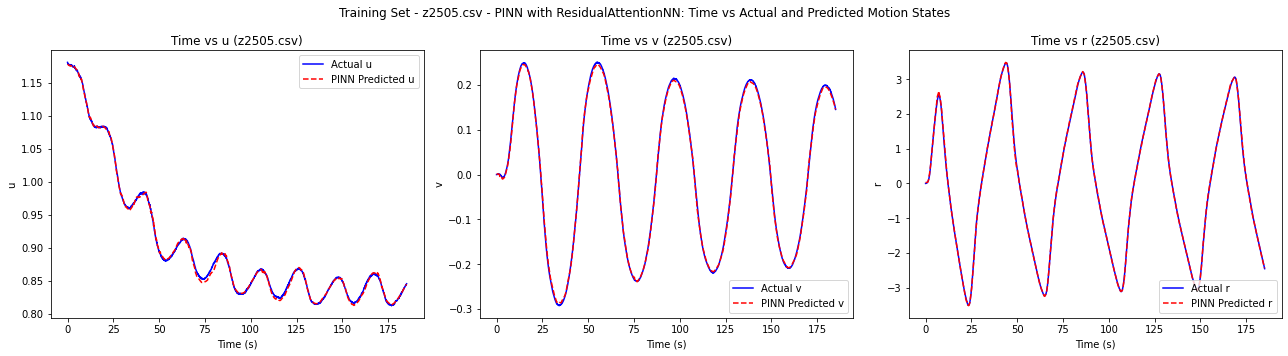

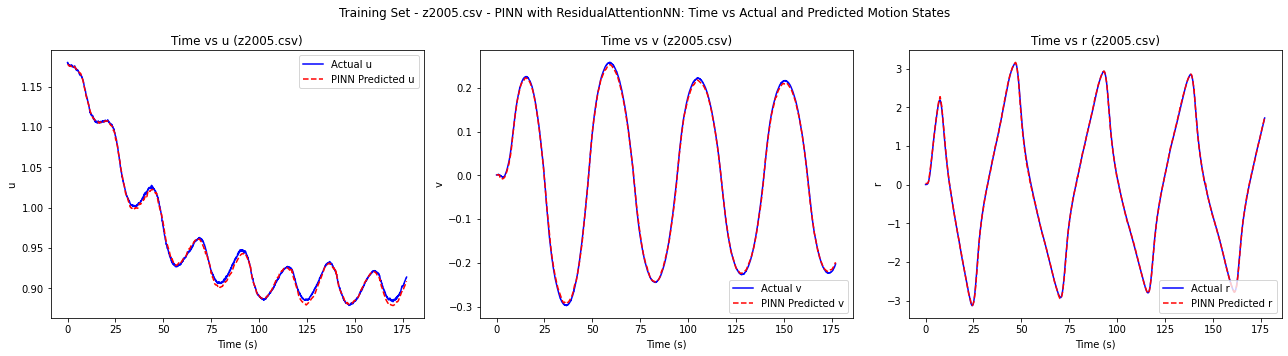

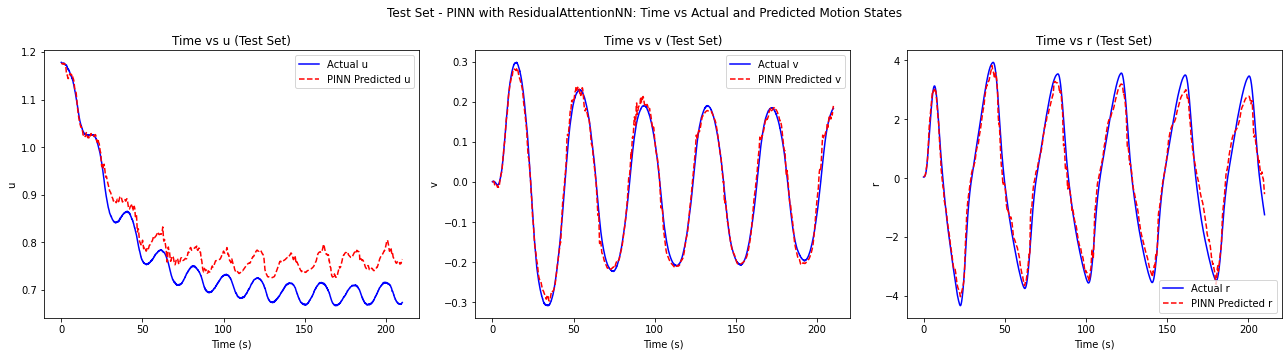

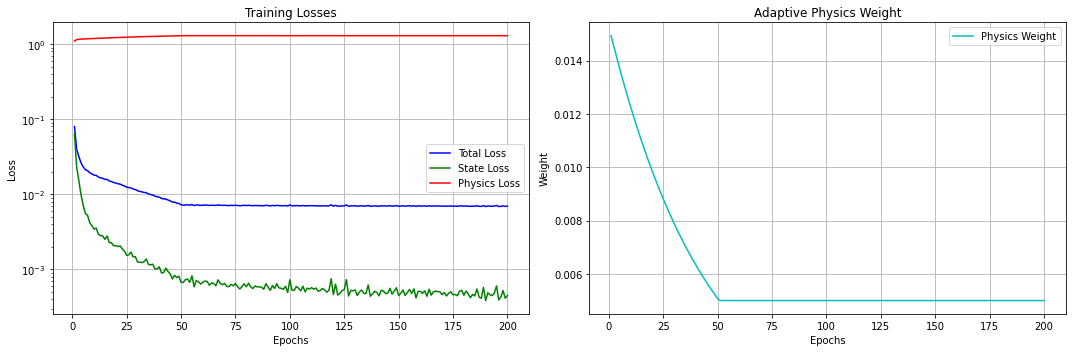

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# 读取SIMMAN2008文件夹下的所有CSV文件（排除z3505.csv作为测试集）
folder_path = 'SIMMAN2008_backup'
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f != 'z3505.csv']

# 修改数据预处理以生成样本对
inputs_train = []
next_states_train = []
ship_states_train = []  # 当前状态
controls_train = []
dts_train = []

for file in file_list:
    data = pd.read_csv(os.path.join(folder_path, file))
    inputs = data[['x', 'y', 'time', 'psi','p', 'delta', 'n']].values
    ship_states = data[['u', 'v', 'r']].values
    controls = data[['delta', 'n']].values
    times = data['time'].values
    
    for i in range(len(inputs) - 1):
        inputs_train.append(inputs[i])
        ship_states_train.append(ship_states[i])
        next_states_train.append(ship_states[i+1])
        controls_train.append(controls[i])
        dts_train.append(times[i+1] - times[i])

# 合并数据并标准化
inputs_train = np.vstack(inputs_train)
ship_states_train = np.vstack(ship_states_train)
next_states_train = np.vstack(next_states_train)
controls_train = np.vstack(controls_train)
dts_train = np.array(dts_train)

# 读取测试集数据（z3505.csv）
test_data = pd.read_csv(os.path.join(folder_path, 'z3505.csv'))
inputs_test = test_data[['x', 'y', 'time', 'psi','p', 'delta', 'n']].values
ship_states_test = test_data[['u', 'v', 'r']].values
controls_test = test_data[['delta', 'n']].values

# 对输入进行标准化
input_scaler = StandardScaler()
inputs_train_scaled = input_scaler.fit_transform(inputs_train)
inputs_test_scaled = input_scaler.transform(inputs_test)

# 对船舶状态进行标准化
state_scaler = StandardScaler()
ship_states_train_scaled = state_scaler.fit_transform(ship_states_train)
next_states_train_scaled = state_scaler.fit_transform(next_states_train)
ship_states_test_scaled = state_scaler.transform(ship_states_test)

# 直接使用原始控制输入
controls_train_scaled = controls_train
controls_test_scaled = controls_test

# 转换为PyTorch张量
X_train = torch.tensor(inputs_train_scaled, dtype=torch.float32)
states_train = torch.tensor(ship_states_train_scaled, dtype=torch.float32)
controls_train_tensor = torch.tensor(controls_train_scaled, dtype=torch.float32)

X_test = torch.tensor(inputs_test_scaled, dtype=torch.float32)
states_test = torch.tensor(ship_states_test_scaled, dtype=torch.float32)
controls_test_tensor = torch.tensor(controls_test_scaled, dtype=torch.float32)

# 创建包含时间差的数据集
train_dataset = TensorDataset(
    torch.tensor(inputs_train_scaled, dtype=torch.float32),
    torch.tensor(ship_states_train_scaled, dtype=torch.float32),
    torch.tensor(next_states_train_scaled, dtype=torch.float32),
    torch.tensor(controls_train, dtype=torch.float32),
    torch.tensor(dts_train, dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 定义PINN的参数（这些参数通常应该从实验或船舶规格中获取）
vessel_params = {
    'Lpp': 7.0,  # 船长 (m)
    'd': 0.455,  # 吃水 (m)
    'displ': 3.2724,  # 排水量 (t)
    'rho': 1030.0,  # 水密度 (kg/m³)
    'D_p': 0.204,  # 螺旋桨直径 (m)
    'x_P': -3.36,  # 螺旋桨位置 (m)
    'x_G': 0.244,  # 重心位置 (m)
    'x_H_dash': -0.464,  # 无因次化的横向力作用点
    'w_P0': 0.4,  # 螺旋桨伴流分数
    'gamma_R_plus': 0.640,  # 舵效率因子 (正漂角)
    'gamma_R_minus': 0.395,  # 舵效率因子 (负漂角)
    'l_R': -0.710,  # 舵位置比
    't_R': 0.387,  # 推力减额系数
    't_P': 0.220,  # 推力减额系数
    'epsilon': 1.09,  # 旋涡伴流系数
    'eta': 0.626,  # 螺旋桨效率
    'kappa': 0.50,  # 螺旋桨-船体相互作用系数
    'A_R': 0.0654,  # 舵面积与L*d之比
    'f_alpha': 2.747,  # 舵升力斜率
    'a_H': 0.312,  # 船体诱导升力系数

    # MMG模型系数 (无因次化)
    'R_0_dash': 0.022,
    'X_vv_dash': -0.040,
    'X_vr_dash': 0.002,
    'X_rr_dash': 0.011,
    'X_vvvv_dash': 0.771,

    'Y_v_dash': -0.315,
    'Y_r_dash': 0.083,
    'Y_vvv_dash': -1.607,
    'Y_vvr_dash': 0.379,
    'Y_vrr_dash': -0.391,
    'Y_rrr_dash': 0.008,

    'N_v_dash': -0.137,
    'N_r_dash': -0.049,
    'N_vvv_dash': -0.030,
    'N_vvr_dash': -0.294,
    'N_vrr_dash': 0.055,
    'N_rrr_dash': -0.013,

    # 附加质量系数 (无因次化)
    'm_x_dash': 0.022,
    'm_y_dash': 0.223,
    'J_z_dash': 0.011,
}

class ShipMotionStatePINN(nn.Module):
    def __init__(self, input_size=7, vessel_params=None):
        super(ShipMotionStatePINN, self).__init__()
        self.vessel = vessel_params
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 用于运动状态预测的网络
        self.dynamics_net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 3)  # 输出u, v, r（曲速，横速，转向速率）
        )

    def forward(self, x):
        # 输出：运动状态预测 (u, v, r)
        motion_state_pred = self.dynamics_net(x)
        return motion_state_pred

    def compute_physics_derivatives(self, uvr, rudder, nps):
        """
        计算基于详细MMG物理模型的导数

        Args:
            uvr (torch.Tensor): 运动状态张量 [u, v, r]
            rudder (torch.Tensor): 舵角 (rad)
            nps (torch.Tensor): 螺旋桨转速 (RPM)

        Returns:
            torch.Tensor: 加速度导数 [du/dt, dv/dt, dr/dt]
        """
        batch_size = uvr.shape[0]
        u, v_m, r = uvr[:, 0], uvr[:, 1], uvr[:, 2]

        # 转换为合适的单位
        r_rad = torch.deg2rad(r)  # 角速度从deg/s转换为rad/s
        delta_rad = torch.deg2rad(rudder)  # 舵角从deg转换为rad
        nps_rps = nps  # RPM转换为RPS

        # 简写船舶参数
        p = self.vessel

        # 计算总速度和无量纲化参数
        U = torch.sqrt(u ** 2 + v_m ** 2)

        # 计算漂角和无量纲参数（添加小量避免除零）
        eps = 1e-6
        beta = torch.atan2(-v_m, u + eps)  # 漂角
        v_dash = v_m / (U + eps)  # 无量纲横向速度
        r_dash = r_rad * p['Lpp'] / (U + eps)  # 无量纲艏摇角速度

        # 螺旋桨伴流计算
        x_P_rel = -0.5  # 假设螺旋桨位置在船长的一半处
        beta_P = beta - (x_P_rel * r_dash)

        # 使用简化的w_P计算
        w_P = p['w_P0'] * torch.exp(-4.0 * beta_P ** 2)

        # 螺旋桨前进系数（添加小量避免除零）
        J = (1 - w_P) * u / (nps_rps * p['D_p'] + eps)

        # 螺旋桨推力系数
        K_T = -0.1476 * J ** 2 - 0.2219 * J + 0.3243

        # 舵参数计算
        beta_R = beta - p['l_R'] * r_dash

        # 流向整流系数
        gamma_R = torch.where(beta_R >= 0,
                              torch.tensor(p['gamma_R_plus'], dtype=beta_R.dtype, device=beta_R.device),
                              torch.tensor(p['gamma_R_minus'], dtype=beta_R.dtype, device=beta_R.device))

        # 舵入流速度
        v_R = U * gamma_R * beta_R

        # 考虑螺旋桨加速影响的舵入流速度
        u_R = u * (1 - w_P)

        # 更精确的螺旋桨-舵相互作用计算
        if p.get('epsilon') is not None and p.get('eta') is not None and p.get('kappa') is not None:
            term = torch.sqrt(1.0 + 8.0 * K_T / (torch.pi * J ** 2 + eps)) - 1
            u_R = u * (1 - w_P) * p['epsilon'] * torch.sqrt(
                p['eta'] * (1.0 + p['kappa'] * term) ** 2 + (1 - p['eta'])
            )

        # 舵入流总速度和角度
        U_R = torch.sqrt(u_R ** 2 + v_R ** 2)
        alpha_R = delta_rad - torch.atan2(v_R, u_R + eps)

        # 舵的法向力
        F_N = 0.5 * p['A_R'] * p['rho'] * \
              p['f_alpha'] * (U_R ** 2) * torch.sin(alpha_R)

        # 船体力
        X_H = (0.5 * p['rho'] * p['Lpp'] * p['d'] * (U ** 2) * (
                -p['R_0_dash']
                + p['X_vv_dash'] * (v_dash ** 2)
                + p['X_vr_dash'] * v_dash * r_dash
                + p['X_rr_dash'] * (r_dash ** 2)
                + p.get('X_vvvv_dash', 0.0) * (v_dash ** 4)  # 如果没有设置则默认为0
        ))

        # 舵力
        X_R = -(1 - p['t_R']) * F_N * torch.sin(delta_rad)

        # 螺旋桨力
        X_P = (1 - p['t_P']) * p['rho'] * K_T * (nps_rps ** 2) * (p['D_p'] ** 4)

        # 横向船体力
        Y_H = (0.5 * p['rho'] * p['Lpp'] * p['d'] * (U ** 2) * (
                p['Y_v_dash'] * v_dash
                + p['Y_r_dash'] * r_dash
                + p['Y_vvv_dash'] * (v_dash ** 3)
                + p['Y_vvr_dash'] * (v_dash ** 2) * r_dash
                + p.get('Y_vrr_dash', 0.0) * v_dash * (r_dash ** 2)
                + p.get('Y_rrr_dash', 0.0) * (r_dash ** 3)
        ))

        # 横向舵力
        Y_R = -(1 + p['a_H']) * F_N * torch.cos(delta_rad)

        # 艏摇力矩(船体)
        N_H = (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'] * (U ** 2) * (
                p['N_v_dash'] * v_dash
                + p['N_r_dash'] * r_dash
                + p['N_vvv_dash'] * (v_dash ** 3)
                + p.get('N_vvr_dash', 0.0) * (v_dash ** 2) * r_dash
                + p.get('N_vrr_dash', 0.0) * v_dash * (r_dash ** 2)
                + p.get('N_rrr_dash', 0.0) * (r_dash ** 3)
        ))

        # 艏摇力矩(舵)
        x_H = p['x_H_dash'] * p['Lpp']
        N_R = -(-0.5 * p['Lpp'] + p['a_H'] * x_H) * F_N * torch.cos(delta_rad)

        # 质量矩阵计算
        m_x = p['m_x_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'])
        m_y = p['m_y_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'])
        J_z = p['J_z_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 4) * p['d'])

        # 船舶质量和回转半径
        m = p['displ'] * p['rho']
        I_zG = m * (0.25 * p['Lpp']) ** 2

        # 构建质量矩阵 (批处理形式)
        zeros = torch.zeros(batch_size, device=u.device)
        ones = torch.ones(batch_size, device=u.device)

        # 刚体质量矩阵
        M_RB_11 = m * ones
        M_RB_22 = m * ones
        M_RB_23 = m * p['x_G'] * ones
        M_RB_32 = m * p['x_G'] * ones
        M_RB_33 = I_zG * ones

        # 附加质量矩阵
        M_A_11 = m_x * ones
        M_A_22 = m_y * ones
        M_A_33 = (J_z + (p['x_G'] ** 2) * m) * ones

        # 总质量矩阵对角元素
        M_11 = M_RB_11 + M_A_11
        M_22 = M_RB_22 + M_A_22
        M_33 = M_RB_33 + M_A_33

        # 总质量矩阵非对角元素
        M_23 = M_RB_23
        M_32 = M_RB_32

        # 科氏力和离心力项
        C_13 = -m * v_m
        C_23 = m * u
        C_31 = -m * v_m
        C_32 = m * u

        # 合力和力矩
        FX = X_H + X_R + X_P
        FY = Y_H + Y_R
        FN = N_H + N_R

        # 运动方程右侧项 (F - C*v)
        RHS_1 = FX - (-m * r_rad * v_m - m * p['x_G'] * r_rad ** 2)
        RHS_2 = FY - (m * r_rad * u)
        RHS_3 = FN - (m * p['x_G'] * r_rad * u)

        # 由于质量矩阵的耦合，我们需要计算完整的逆矩阵，这里采用简化处理
        # 考虑主要对角元素和一些关键的非对角元素
        det = M_11 * (M_22 * M_33 - M_23 * M_32)

        # 计算加速度 (考虑简化版本以避免复杂的批处理矩阵求逆)
        du_dt = RHS_1 / M_11
        dv_dt = (RHS_2 * M_33 - RHS_3 * M_23) / (M_22 * M_33 - M_23 * M_32)
        dr_dt = (RHS_3 * M_22 - RHS_2 * M_32) / (M_22 * M_33 - M_23 * M_32)

        # 将角速度从rad/s转回deg/s
        dr_dt = torch.rad2deg(dr_dt)

        # 组合导数
        derivatives = torch.stack([du_dt, dv_dt, dr_dt], dim=1)
        return derivatives

    def compute_forward_diff(self, batch_inputs, batch_states, dt=0.1):
        """
        使用前向差分计算状态变化率

        Args:
            batch_inputs: 输入特征批次 [B, 8]
            batch_states: 状态预测批次 [B, 3]
            dt: 时间步长 (默认0.1秒)

        Returns:
            torch.Tensor: 计算得到的状态变化率 [B-1, 3]
        """
        # 确保至少有两个时间步的数据
        if batch_inputs.shape[0] < 2:
            return torch.zeros((0, 3), device=batch_inputs.device)

        # 时间索引 (我们假设第3列是时间，对应'time(s)')
        time_idx = 2

        # 提取时间值
        time_values = batch_inputs[:, time_idx]

        # 计算有序的时间索引
        sorted_indices = torch.argsort(time_values)

        # 根据时间排序输入和状态
        sorted_inputs = batch_inputs[sorted_indices]
        sorted_states = batch_states[sorted_indices]
        sorted_times = time_values[sorted_indices]

        # 计算真实时间差
        time_diffs = sorted_times[1:] - sorted_times[:-1]
        # 将小于1e-6的时间差设为 dt 以避免除零错误
        time_diffs = torch.where(time_diffs < 1e-6, torch.tensor(dt, device=time_diffs.device), time_diffs)

        # 计算前向差分
        state_diffs = sorted_states[1:] - sorted_states[:-1]
        state_derivatives = state_diffs / time_diffs.unsqueeze(1)

        return state_derivatives, sorted_inputs[:-1], sorted_states[:-1]


# 自适应权重模块
class AdaptiveWeightModule:
    """基于损失比例的自适应权重模块"""

    def __init__(self, initial_weight=0.5, min_weight=0.1, max_weight=10.0,
                 adaptation_rate=0.05, smoothing_factor=0.9):
        """
        初始化自适应权重模块

        Args:
            initial_weight: 初始物理约束权重
            min_weight: 最小权重
            max_weight: 最大权重
            adaptation_rate: 权重调整速率
            smoothing_factor: 平滑因子，避免权重剧烈波动
        """
        self.current_weight = initial_weight
        self.min_weight = min_weight
        self.max_weight = max_weight
        self.adaptation_rate = adaptation_rate
        self.smoothing_factor = smoothing_factor
        self.running_data_loss = None
        self.running_physics_loss = None

    def update_weight(self, data_loss, physics_loss):
        """
        根据数据损失和物理损失的相对大小更新权重

        Args:
            data_loss: 当前批次的数据损失
            physics_loss: 当前批次的物理损失

        Returns:
            float: 更新后的权重
        """
        # 初始化或更新指数移动平均
        if self.running_data_loss is None:
            self.running_data_loss = data_loss
        else:
            self.running_data_loss = (self.smoothing_factor * self.running_data_loss +
                                      (1 - self.smoothing_factor) * data_loss)

        if self.running_physics_loss is None:
            self.running_physics_loss = physics_loss
        else:
            self.running_physics_loss = (self.smoothing_factor * self.running_physics_loss +
                                         (1 - self.smoothing_factor) * physics_loss)

        # 避免除零错误
        eps = 1e-8

        # 计算损失比例
        loss_ratio = self.running_data_loss / (self.running_physics_loss + eps)

        # 调整权重: 如果数据损失远大于物理损失，增加物理权重
        target_weight = self.current_weight * (1.0 + self.adaptation_rate * (loss_ratio - 1.0))

        # 限制权重在有效范围内
        target_weight = max(self.min_weight, min(self.max_weight, target_weight))

        # 平滑过渡到目标权重
        self.current_weight = (self.smoothing_factor * self.current_weight +
                               (1 - self.smoothing_factor) * target_weight)

        return self.current_weight

    def get_weight(self):
        """获取当前权重值"""
        return self.current_weight


# 修改后的训练循环
def train_pinn_with_enhancements(model, train_loader, optimizer, epochs=300):
    """
    使用前向差分和自适应权重训练PINN模型
    """
    # 损失函数
    state_criterion = nn.SmoothL1Loss(beta=0.5)  # 状态预测损失

    # 初始化自适应权重模块        
    adaptive_weight = AdaptiveWeightModule(
        initial_weight=0.015,
        min_weight=0.005,
        max_weight=1.5,
        adaptation_rate=0.002,
        smoothing_factor=0.98
    )

    # 训练记录
    loss_history = {
        'total_loss': [],
        'state_loss': [],
        'physics_loss': [],
        'physics_weight': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_state_loss = 0.0
        running_physics_loss = 0.0
        running_physics_weight = 0.0

        for batch in train_loader:
            inputs_batch, states_batch, next_states_batch, controls_batch, dts_batch = batch
            optimizer.zero_grad()

            # 预测当前状态
            motion_state_pred = model(inputs_batch)
            state_loss = state_criterion(motion_state_pred, states_batch)

            # 计算物理导数
            physics_derivatives = model.compute_physics_derivatives(
                motion_state_pred, 
                controls_batch[:, 0], 
                controls_batch[:, 1]
            )

            # 真实导数为（下一状态 - 当前状态）/dt
            real_derivatives = (next_states_batch - states_batch) / dts_batch.unsqueeze(1)
            physics_loss = state_criterion(physics_derivatives, real_derivatives)

            # 3. 更新自适应权重
            physics_weight = adaptive_weight.update_weight(state_loss.item(), physics_loss.item())

            # 4. 计算总损失
            total_loss = state_loss + physics_weight * physics_loss

            # 5. 反向传播和优化
            total_loss.backward()
            optimizer.step()

            # 累计损失
            running_loss += total_loss.item()
            running_state_loss += state_loss.item()
            running_physics_loss += physics_loss.item()
            running_physics_weight += physics_weight

        # 计算epoch平均损失
        avg_total_loss = running_loss / len(train_loader)
        avg_state_loss = running_state_loss / len(train_loader)
        avg_physics_loss = running_physics_loss / len(train_loader)
        avg_physics_weight = running_physics_weight / len(train_loader)

        # 记录训练历史
        loss_history['total_loss'].append(avg_total_loss)
        loss_history['state_loss'].append(avg_state_loss)
        loss_history['physics_loss'].append(avg_physics_loss)
        loss_history['physics_weight'].append(avg_physics_weight)

        # 每50个epoch输出一次损失
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], '
                  f'Total Loss: {avg_total_loss:.8f}, '
                  f'State Loss: {avg_state_loss:.8f}, '
                  f'Physics Loss: {avg_physics_loss:.8f}, '
                  f'Physics Weight: {avg_physics_weight:.4f}')

    # 返回训练历史
    return loss_history


# 创建模型和优化器
model = ShipMotionStatePINN(input_size=7, vessel_params=vessel_params)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)

# 使用增强版训练循环训练模型
loss_history = train_pinn_with_enhancements(model, train_loader, optimizer, epochs=200)

# 预测并绘图
model.eval()
with torch.no_grad():
    states_train_pred = model(X_train)
    states_test_pred = model(X_test)
    states_train_pred = states_train_pred.numpy()
    states_test_pred = states_test_pred.numpy()

# 反归一化预测结果
states_train_pred = state_scaler.inverse_transform(states_train_pred)
states_test_pred = state_scaler.inverse_transform(states_test_pred)

# 反归一化真实目标值
states_train_original = state_scaler.inverse_transform(ship_states_train_scaled)
states_test_original = state_scaler.inverse_transform(ship_states_test_scaled)

print("训练完成，下面生成图样：")

# 获取时间数据
time_train_list = [pd.read_csv(os.path.join(folder_path, file))['time'].values for file in file_list]
time_test = test_data['time'].values

# 状态变量名称
state_names = ['u', 'v', 'r']

# 分别绘制每个文件的训练集时间-状态曲线
for i, file in enumerate(file_list):
    # 获取每个文件的数据
    data = pd.read_csv(os.path.join(folder_path, file))
    states = data[['u', 'v', 'r']].values
    time_train = data['time'].values

    # 索引范围，用于从合并数据中提取出当前文件对应的预测值
    if i == 0:
        start_idx = 0
    else:
        prev_files_lengths = [len(pd.read_csv(os.path.join(folder_path, f))) - 1 for f in file_list[:i]]
        start_idx = sum(prev_files_lengths)
    
    end_idx = start_idx + len(states) - 1  # -1 because we create n-1 samples from n data points

    # 获取当前文件的预测结果
    states_train_pred_current = states_train_pred[start_idx:end_idx]

    # 绘制当前文件的时间-状态曲线 - 注意使用time_train[:-1]以匹配预测长度
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Training Set - {file} - PINN with ResidualAttentionNN: Time vs Actual and Predicted Motion States')

    for j in range(3):
        axs[j].plot(time_train, states[:, j], 'b-', label=f'Actual {state_names[j]}')
        # 使用除了最后一个点之外的时间数据，以匹配预测数据的长度
        axs[j].plot(time_train[:-1], states_train_pred_current[:, j], 'r--', label=f'PINN Predicted {state_names[j]}')
        axs[j].set_title(f'Time vs {state_names[j]} ({file})')
        axs[j].set_xlabel('Time (s)')
        axs[j].set_ylabel(state_names[j])
        axs[j].legend()

    plt.tight_layout()
    plt.show()

# 绘制测试集时间-状态曲线
fig_test_time, axs_test_time = plt.subplots(1, 3, figsize=(18, 5))
fig_test_time.suptitle('Test Set - PINN with ResidualAttentionNN: Time vs Actual and Predicted Motion States')

for j in range(3):
    axs_test_time[j].plot(time_test, ship_states_test[:, j], 'b-', label=f'Actual {state_names[j]}')
    # 确保预测数据和时间数据长度一致
    if len(states_test_pred) != len(time_test):
        min_len = min(len(states_test_pred), len(time_test))
        axs_test_time[j].plot(time_test[:min_len], states_test_pred[:min_len, j], 'r--', label=f'PINN Predicted {state_names[j]}')
    else:
        axs_test_time[j].plot(time_test, states_test_pred[:, j], 'r--', label=f'PINN Predicted {state_names[j]}')
    axs_test_time[j].set_title(f'Time vs {state_names[j]} (Test Set)')
    axs_test_time[j].set_xlabel('Time (s)')
    axs_test_time[j].set_ylabel(state_names[j])
    axs_test_time[j].legend()

plt.tight_layout()
plt.show()


# 可视化训练过程
def plot_training_history(loss_history):
    """绘制训练历史曲线"""
    epochs = range(1, len(loss_history['total_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制损失曲线
    ax1.plot(epochs, loss_history['total_loss'], 'b-', label='Total Loss')
    ax1.plot(epochs, loss_history['state_loss'], 'g-', label='State Loss')
    ax1.plot(epochs, loss_history['physics_loss'], 'r-', label='Physics Loss')
    ax1.set_title('Training Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True)

    # 绘制物理权重曲线
    ax2.plot(epochs, loss_history['physics_weight'], 'c-', label='Physics Weight')
    ax2.set_title('Adaptive Physics Weight')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Weight')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# 训练完成后绘制训练历史
plot_training_history(loss_history)

## 2. MLP+PINN模型表现测试

Epoch [20/200], Total Loss: 0.01432632, State Loss: 0.00172461, Physics Loss: 1.29044003, Physics Weight: 0.0098
Epoch [40/200], Total Loss: 0.00922031, State Loss: 0.00082077, Physics Loss: 1.34564547, Physics Weight: 0.0062
Epoch [60/200], Total Loss: 0.00746476, State Loss: 0.00063314, Physics Loss: 1.36632464, Physics Weight: 0.0050
Epoch [80/200], Total Loss: 0.00733846, State Loss: 0.00050700, Physics Loss: 1.36629221, Physics Weight: 0.0050
Epoch [100/200], Total Loss: 0.00738201, State Loss: 0.00055261, Physics Loss: 1.36587950, Physics Weight: 0.0050
Epoch [120/200], Total Loss: 0.00732936, State Loss: 0.00049947, Physics Loss: 1.36597635, Physics Weight: 0.0050
Epoch [140/200], Total Loss: 0.00729511, State Loss: 0.00046645, Physics Loss: 1.36573214, Physics Weight: 0.0050
Epoch [160/200], Total Loss: 0.00725087, State Loss: 0.00042447, Physics Loss: 1.36527982, Physics Weight: 0.0050
Epoch [180/200], Total Loss: 0.00723811, State Loss: 0.00040955, Physics Loss: 1.36571220, P

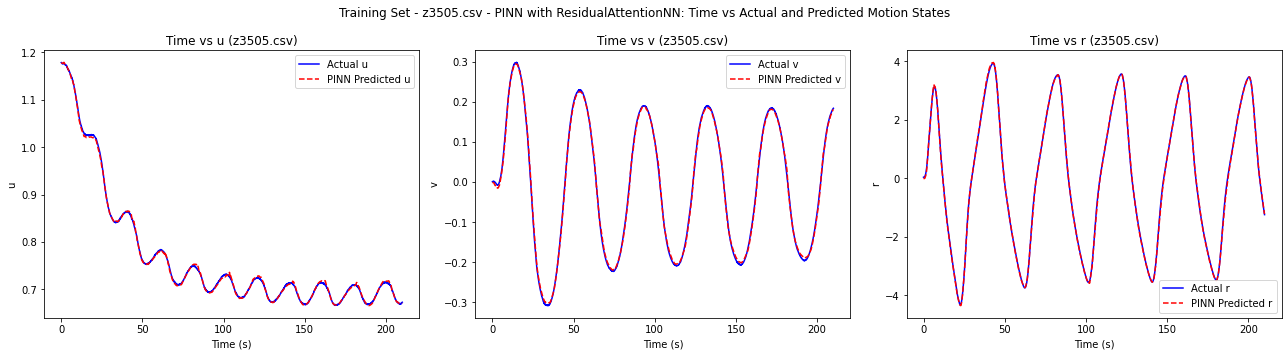

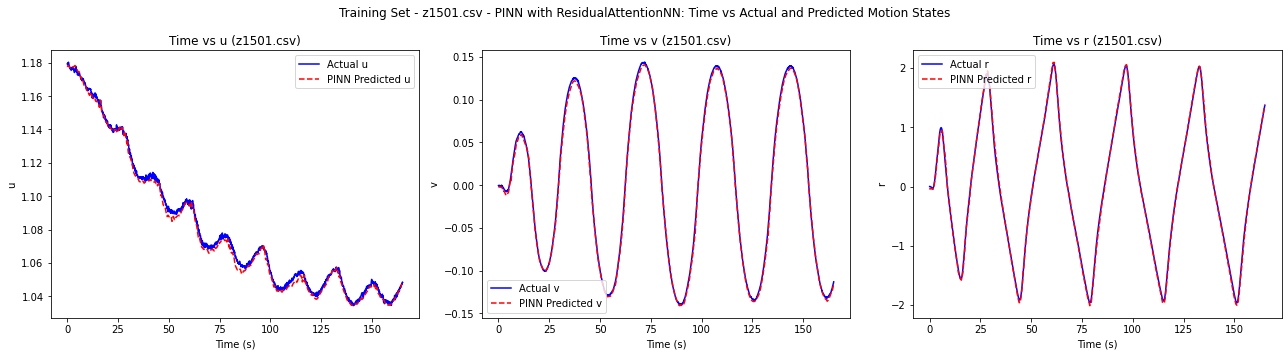

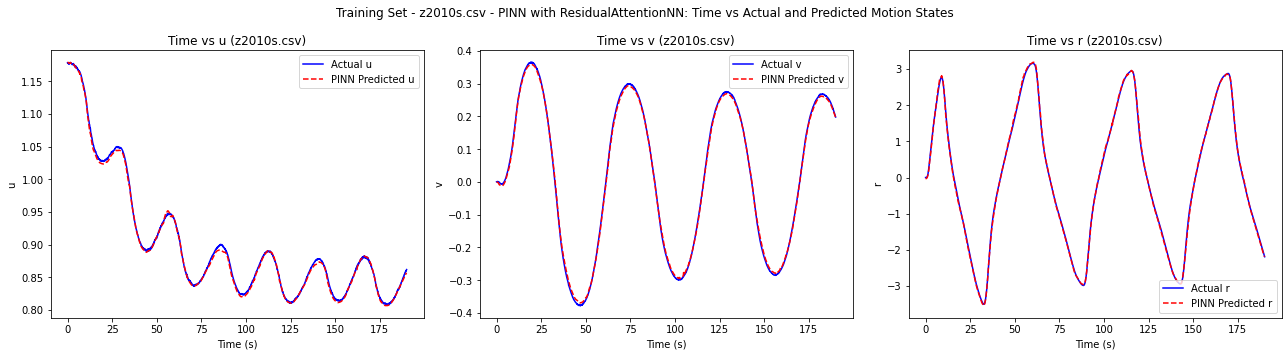

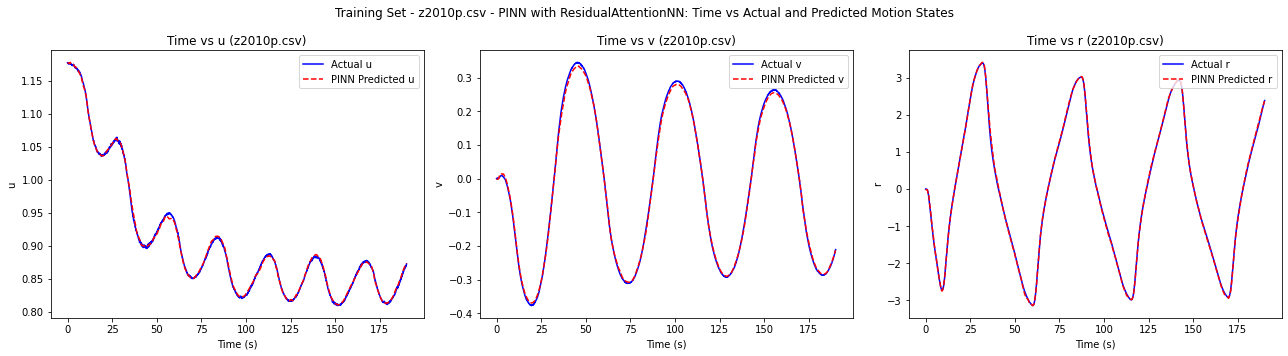

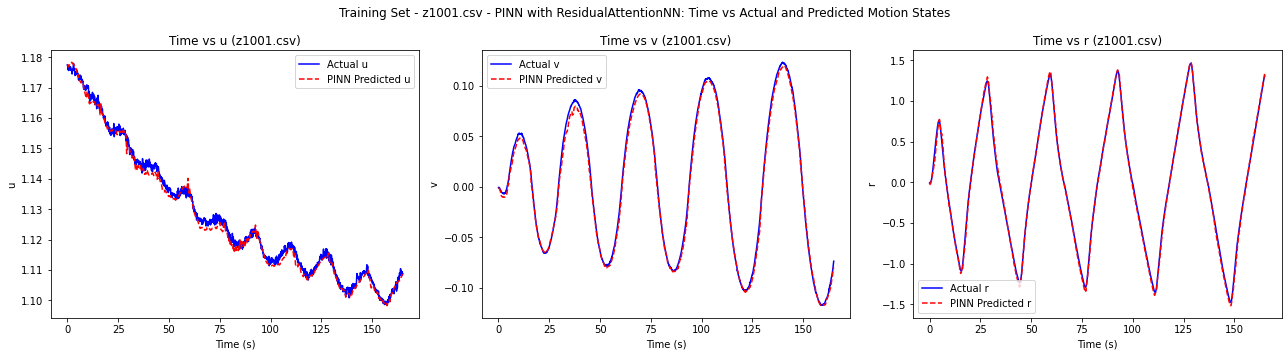

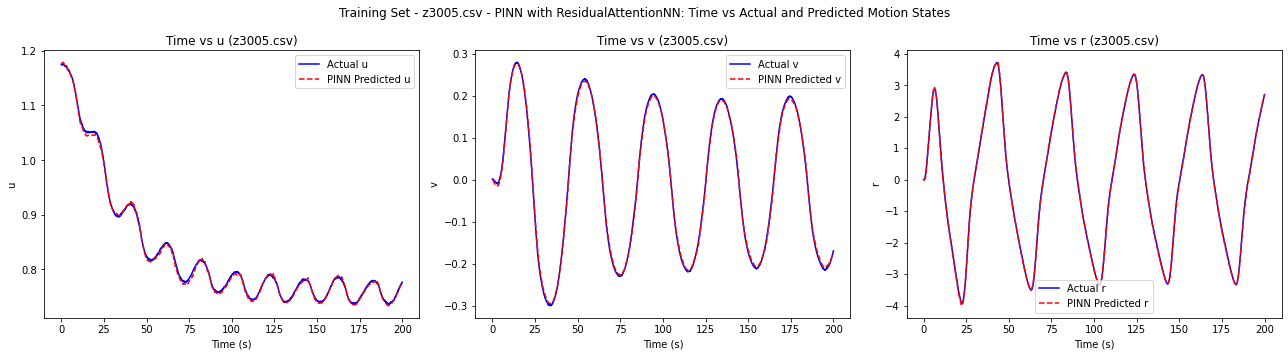

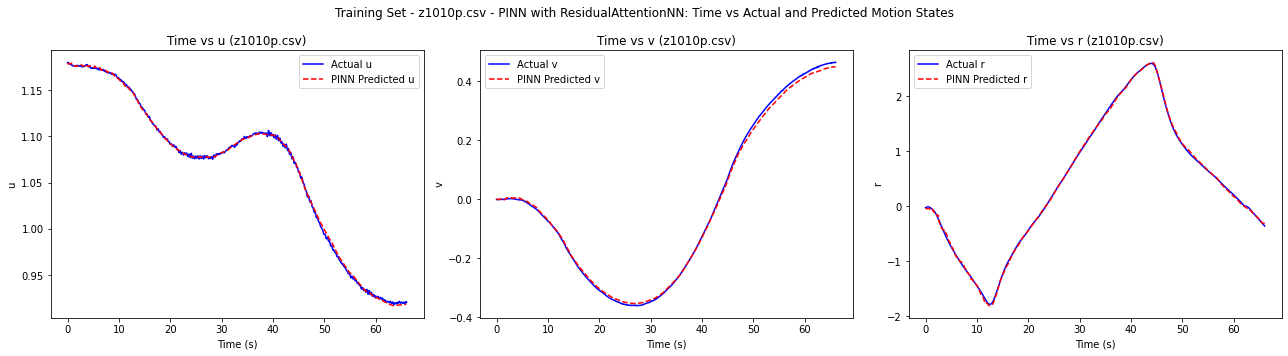

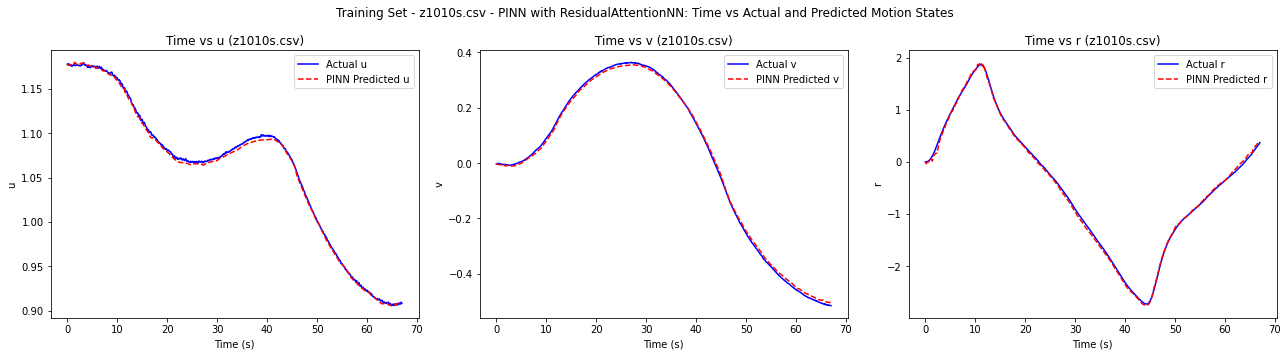

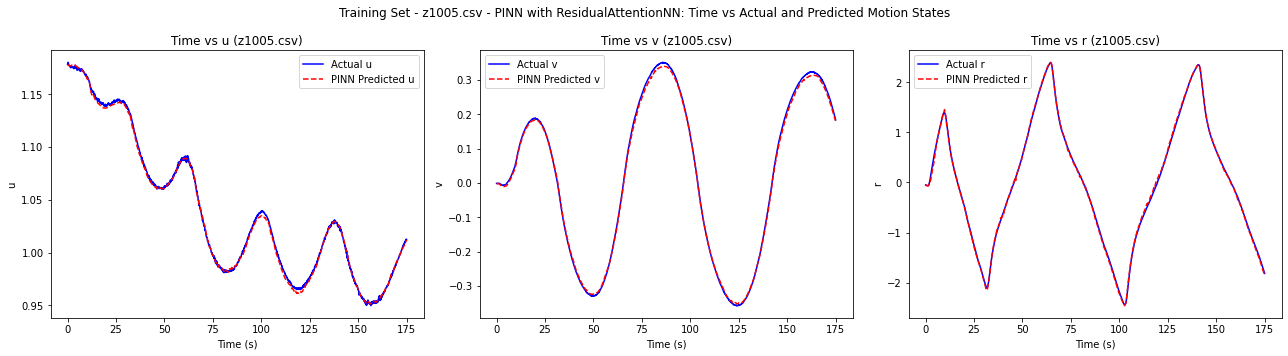

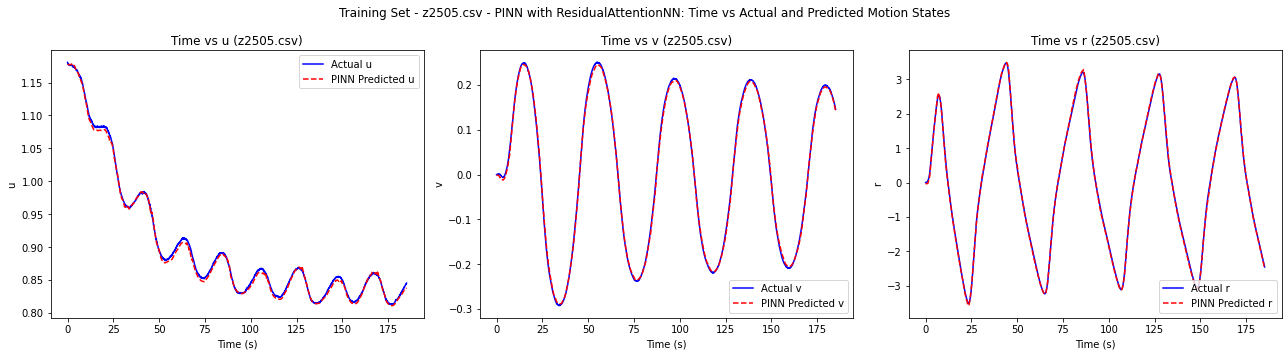

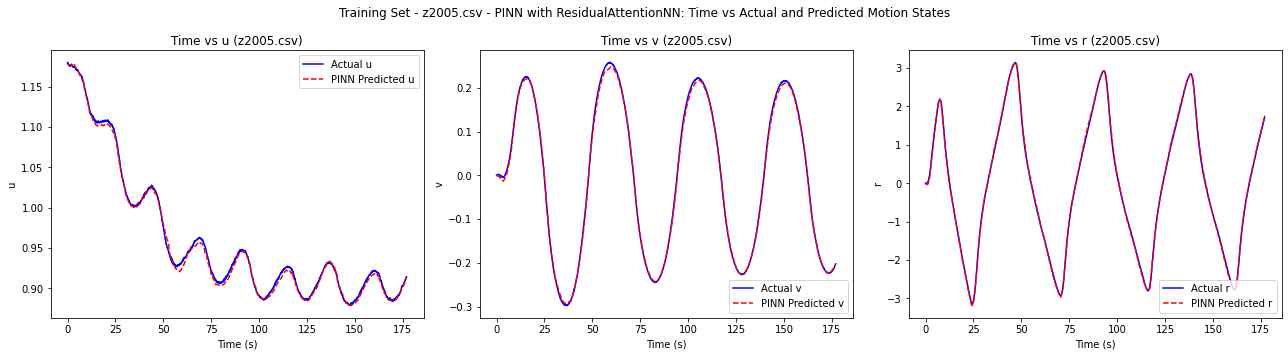

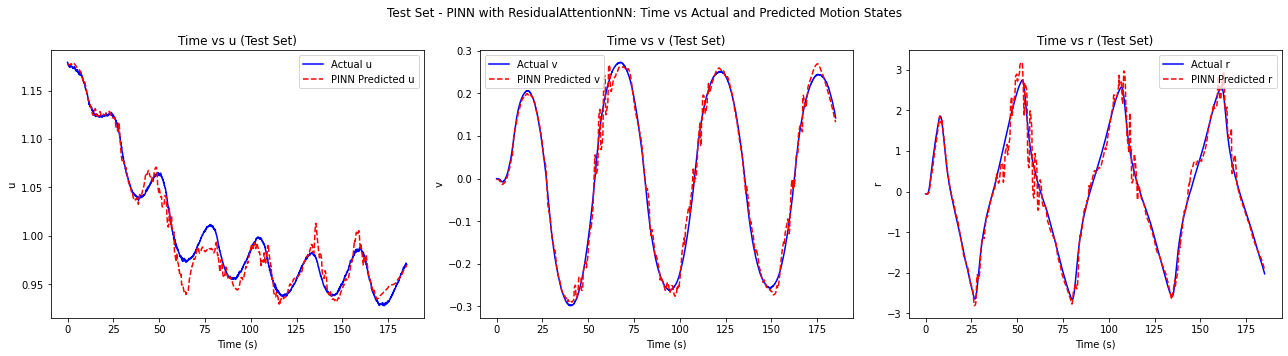

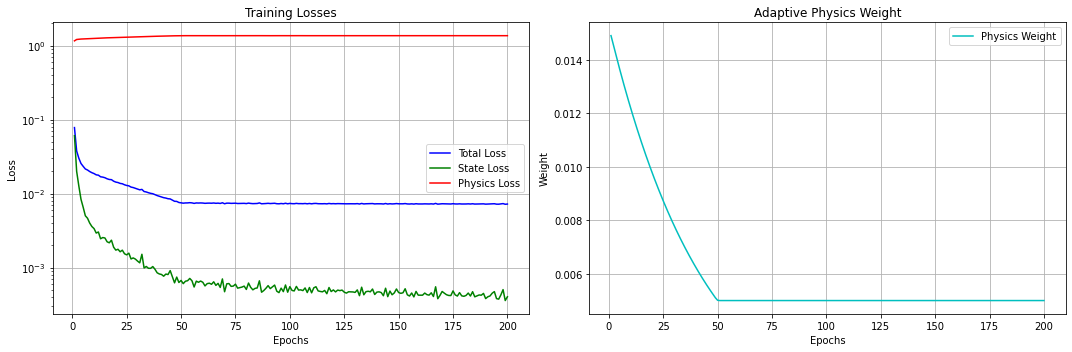

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# 读取SIMMAN2008文件夹下的所有CSV文件（排除z3505.csv作为测试集）
folder_path = 'SIMMAN2008_backup'
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f != 'z1505.csv']

# 修改数据预处理以生成样本对
inputs_train = []
next_states_train = []
ship_states_train = []  # 当前状态
controls_train = []
dts_train = []

for file in file_list:
    data = pd.read_csv(os.path.join(folder_path, file))
    inputs = data[['x', 'y', 'time', 'psi', 'p', 'delta', 'n']].values
    ship_states = data[['u', 'v', 'r']].values
    controls = data[['delta', 'n']].values
    times = data['time'].values

    for i in range(len(inputs) - 1):
        inputs_train.append(inputs[i])
        ship_states_train.append(ship_states[i])
        next_states_train.append(ship_states[i + 1])
        controls_train.append(controls[i])
        dts_train.append(times[i + 1] - times[i])

# 合并数据并标准化
inputs_train = np.vstack(inputs_train)
ship_states_train = np.vstack(ship_states_train)
next_states_train = np.vstack(next_states_train)
controls_train = np.vstack(controls_train)
dts_train = np.array(dts_train)

# 读取测试集数据（z3505.csv）
test_data = pd.read_csv(os.path.join(folder_path, 'z1505.csv'))
inputs_test = test_data[['x', 'y', 'time', 'psi', 'p', 'delta', 'n']].values
ship_states_test = test_data[['u', 'v', 'r']].values
controls_test = test_data[['delta', 'n']].values

# 对输入进行标准化
input_scaler = StandardScaler()
inputs_train_scaled = input_scaler.fit_transform(inputs_train)
inputs_test_scaled = input_scaler.transform(inputs_test)

# 对船舶状态进行标准化
state_scaler = StandardScaler()
ship_states_train_scaled = state_scaler.fit_transform(ship_states_train)
next_states_train_scaled = state_scaler.fit_transform(next_states_train)
ship_states_test_scaled = state_scaler.transform(ship_states_test)

# 直接使用原始控制输入
controls_train_scaled = controls_train
controls_test_scaled = controls_test

# 转换为PyTorch张量
X_train = torch.tensor(inputs_train_scaled, dtype=torch.float32)
states_train = torch.tensor(ship_states_train_scaled, dtype=torch.float32)
controls_train_tensor = torch.tensor(controls_train_scaled, dtype=torch.float32)

X_test = torch.tensor(inputs_test_scaled, dtype=torch.float32)
states_test = torch.tensor(ship_states_test_scaled, dtype=torch.float32)
controls_test_tensor = torch.tensor(controls_test_scaled, dtype=torch.float32)

# 创建包含时间差的数据集
train_dataset = TensorDataset(
    torch.tensor(inputs_train_scaled, dtype=torch.float32),
    torch.tensor(ship_states_train_scaled, dtype=torch.float32),
    torch.tensor(next_states_train_scaled, dtype=torch.float32),
    torch.tensor(controls_train, dtype=torch.float32),
    torch.tensor(dts_train, dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 定义PINN的参数（这些参数通常应该从实验或船舶规格中获取）
vessel_params = {
    'Lpp': 7.0,  # 船长 (m)
    'd': 0.455,  # 吃水 (m)
    'displ': 3.2724,  # 排水量 (t)
    'rho': 1030.0,  # 水密度 (kg/m³)
    'D_p': 0.204,  # 螺旋桨直径 (m)
    'x_P': -3.36,  # 螺旋桨位置 (m)
    'x_G': 0.244,  # 重心位置 (m)
    'x_H_dash': -0.464,  # 无因次化的横向力作用点
    'w_P0': 0.4,  # 螺旋桨伴流分数
    'gamma_R_plus': 0.640,  # 舵效率因子 (正漂角)
    'gamma_R_minus': 0.395,  # 舵效率因子 (负漂角)
    'l_R': -0.710,  # 舵位置比
    't_R': 0.387,  # 推力减额系数
    't_P': 0.220,  # 推力减额系数
    'epsilon': 1.09,  # 旋涡伴流系数
    'eta': 0.626,  # 螺旋桨效率
    'kappa': 0.50,  # 螺旋桨-船体相互作用系数
    'A_R': 0.0654,  # 舵面积与L*d之比
    'f_alpha': 2.747,  # 舵升力斜率
    'a_H': 0.312,  # 船体诱导升力系数

    # MMG模型系数 (无因次化)
    'R_0_dash': 0.022,
    'X_vv_dash': -0.040,
    'X_vr_dash': 0.002,
    'X_rr_dash': 0.011,
    'X_vvvv_dash': 0.771,

    'Y_v_dash': -0.315,
    'Y_r_dash': 0.083,
    'Y_vvv_dash': -1.607,
    'Y_vvr_dash': 0.379,
    'Y_vrr_dash': -0.391,
    'Y_rrr_dash': 0.008,

    'N_v_dash': -0.137,
    'N_r_dash': -0.049,
    'N_vvv_dash': -0.030,
    'N_vvr_dash': -0.294,
    'N_vrr_dash': 0.055,
    'N_rrr_dash': -0.013,

    # 附加质量系数 (无因次化)
    'm_x_dash': 0.022,
    'm_y_dash': 0.223,
    'J_z_dash': 0.011,
}


class ShipMotionStatePINN(nn.Module):
    def __init__(self, input_size=7, vessel_params=None):
        super(ShipMotionStatePINN, self).__init__()
        self.vessel = vessel_params
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 用于运动状态预测的网络
        self.dynamics_net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 3)  # 输出u, v, r（曲速，横速，转向速率）
        )

    def forward(self, x):
        # 输出：运动状态预测 (u, v, r)
        motion_state_pred = self.dynamics_net(x)
        return motion_state_pred

    def compute_physics_derivatives(self, uvr, rudder, nps):
        """
        计算基于详细MMG物理模型的导数

        Args:
            uvr (torch.Tensor): 运动状态张量 [u, v, r]
            rudder (torch.Tensor): 舵角 (rad)
            nps (torch.Tensor): 螺旋桨转速 (RPM)

        Returns:
            torch.Tensor: 加速度导数 [du/dt, dv/dt, dr/dt]
        """
        batch_size = uvr.shape[0]
        u, v_m, r = uvr[:, 0], uvr[:, 1], uvr[:, 2]

        # 转换为合适的单位
        r_rad = torch.deg2rad(r)  # 角速度从deg/s转换为rad/s
        delta_rad = torch.deg2rad(rudder)  # 舵角从deg转换为rad
        nps_rps = nps  # RPM转换为RPS

        # 简写船舶参数
        p = self.vessel

        # 计算总速度和无量纲化参数
        U = torch.sqrt(u ** 2 + v_m ** 2)

        # 计算漂角和无量纲参数（添加小量避免除零）
        eps = 1e-6
        beta = torch.atan2(-v_m, u + eps)  # 漂角
        v_dash = v_m / (U + eps)  # 无量纲横向速度
        r_dash = r_rad * p['Lpp'] / (U + eps)  # 无量纲艏摇角速度

        # 螺旋桨伴流计算
        x_P_rel = -0.5  # 假设螺旋桨位置在船长的一半处
        beta_P = beta - (x_P_rel * r_dash)

        # 使用简化的w_P计算
        w_P = p['w_P0'] * torch.exp(-4.0 * beta_P ** 2)

        # 螺旋桨前进系数（添加小量避免除零）
        J = (1 - w_P) * u / (nps_rps * p['D_p'] + eps)

        # 螺旋桨推力系数
        K_T = -0.1476 * J ** 2 - 0.2219 * J + 0.3243

        # 舵参数计算
        beta_R = beta - p['l_R'] * r_dash

        # 流向整流系数
        gamma_R = torch.where(beta_R >= 0,
                              torch.tensor(p['gamma_R_plus'], dtype=beta_R.dtype, device=beta_R.device),
                              torch.tensor(p['gamma_R_minus'], dtype=beta_R.dtype, device=beta_R.device))

        # 舵入流速度
        v_R = U * gamma_R * beta_R

        # 考虑螺旋桨加速影响的舵入流速度
        u_R = u * (1 - w_P)

        # 更精确的螺旋桨-舵相互作用计算
        if p.get('epsilon') is not None and p.get('eta') is not None and p.get('kappa') is not None:
            term = torch.sqrt(1.0 + 8.0 * K_T / (torch.pi * J ** 2 + eps)) - 1
            u_R = u * (1 - w_P) * p['epsilon'] * torch.sqrt(
                p['eta'] * (1.0 + p['kappa'] * term) ** 2 + (1 - p['eta'])
            )

        # 舵入流总速度和角度
        U_R = torch.sqrt(u_R ** 2 + v_R ** 2)
        alpha_R = delta_rad - torch.atan2(v_R, u_R + eps)

        # 舵的法向力
        F_N = 0.5 * p['A_R'] * p['rho'] * \
              p['f_alpha'] * (U_R ** 2) * torch.sin(alpha_R)

        # 船体力
        X_H = (0.5 * p['rho'] * p['Lpp'] * p['d'] * (U ** 2) * (
                -p['R_0_dash']
                + p['X_vv_dash'] * (v_dash ** 2)
                + p['X_vr_dash'] * v_dash * r_dash
                + p['X_rr_dash'] * (r_dash ** 2)
                + p.get('X_vvvv_dash', 0.0) * (v_dash ** 4)  # 如果没有设置则默认为0
        ))

        # 舵力
        X_R = -(1 - p['t_R']) * F_N * torch.sin(delta_rad)

        # 螺旋桨力
        X_P = (1 - p['t_P']) * p['rho'] * K_T * (nps_rps ** 2) * (p['D_p'] ** 4)

        # 横向船体力
        Y_H = (0.5 * p['rho'] * p['Lpp'] * p['d'] * (U ** 2) * (
                p['Y_v_dash'] * v_dash
                + p['Y_r_dash'] * r_dash
                + p['Y_vvv_dash'] * (v_dash ** 3)
                + p['Y_vvr_dash'] * (v_dash ** 2) * r_dash
                + p.get('Y_vrr_dash', 0.0) * v_dash * (r_dash ** 2)
                + p.get('Y_rrr_dash', 0.0) * (r_dash ** 3)
        ))

        # 横向舵力
        Y_R = -(1 + p['a_H']) * F_N * torch.cos(delta_rad)

        # 艏摇力矩(船体)
        N_H = (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'] * (U ** 2) * (
                p['N_v_dash'] * v_dash
                + p['N_r_dash'] * r_dash
                + p['N_vvv_dash'] * (v_dash ** 3)
                + p.get('N_vvr_dash', 0.0) * (v_dash ** 2) * r_dash
                + p.get('N_vrr_dash', 0.0) * v_dash * (r_dash ** 2)
                + p.get('N_rrr_dash', 0.0) * (r_dash ** 3)
        ))

        # 艏摇力矩(舵)
        x_H = p['x_H_dash'] * p['Lpp']
        N_R = -(-0.5 * p['Lpp'] + p['a_H'] * x_H) * F_N * torch.cos(delta_rad)

        # 质量矩阵计算
        m_x = p['m_x_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'])
        m_y = p['m_y_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 2) * p['d'])
        J_z = p['J_z_dash'] * (0.5 * p['rho'] * (p['Lpp'] ** 4) * p['d'])

        # 船舶质量和回转半径
        m = p['displ'] * p['rho']
        I_zG = m * (0.25 * p['Lpp']) ** 2

        # 构建质量矩阵 (批处理形式)
        zeros = torch.zeros(batch_size, device=u.device)
        ones = torch.ones(batch_size, device=u.device)

        # 刚体质量矩阵
        M_RB_11 = m * ones
        M_RB_22 = m * ones
        M_RB_23 = m * p['x_G'] * ones
        M_RB_32 = m * p['x_G'] * ones
        M_RB_33 = I_zG * ones

        # 附加质量矩阵
        M_A_11 = m_x * ones
        M_A_22 = m_y * ones
        M_A_33 = (J_z + (p['x_G'] ** 2) * m) * ones

        # 总质量矩阵对角元素
        M_11 = M_RB_11 + M_A_11
        M_22 = M_RB_22 + M_A_22
        M_33 = M_RB_33 + M_A_33

        # 总质量矩阵非对角元素
        M_23 = M_RB_23
        M_32 = M_RB_32

        # 科氏力和离心力项
        C_13 = -m * v_m
        C_23 = m * u
        C_31 = -m * v_m
        C_32 = m * u

        # 合力和力矩
        FX = X_H + X_R + X_P
        FY = Y_H + Y_R
        FN = N_H + N_R

        # 运动方程右侧项 (F - C*v)
        RHS_1 = FX - (-m * r_rad * v_m - m * p['x_G'] * r_rad ** 2)
        RHS_2 = FY - (m * r_rad * u)
        RHS_3 = FN - (m * p['x_G'] * r_rad * u)

        # 由于质量矩阵的耦合，我们需要计算完整的逆矩阵，这里采用简化处理
        # 考虑主要对角元素和一些关键的非对角元素
        det = M_11 * (M_22 * M_33 - M_23 * M_32)

        # 计算加速度 (考虑简化版本以避免复杂的批处理矩阵求逆)
        du_dt = RHS_1 / M_11
        dv_dt = (RHS_2 * M_33 - RHS_3 * M_23) / (M_22 * M_33 - M_23 * M_32)
        dr_dt = (RHS_3 * M_22 - RHS_2 * M_32) / (M_22 * M_33 - M_23 * M_32)

        # 将角速度从rad/s转回deg/s
        dr_dt = torch.rad2deg(dr_dt)

        # 组合导数
        derivatives = torch.stack([du_dt, dv_dt, dr_dt], dim=1)
        return derivatives
    
    def compute_forward_diff(self, batch_inputs, batch_states, dt=0.1, k=3):
        """
        使用前后k个值的均值计算状态变化率

        Args:
            batch_inputs: 输入特征批次 [B, 8]
            batch_states: 状态预测批次 [B, 3]
            dt: 时间步长 (默认0.1秒)
            k: 前后均值的窗口大小 (默认2)

        Returns:
            torch.Tensor: 计算得到的状态变化率 [B-(2*k), 3]
        """
        # 确保有足够的数据点
        if batch_inputs.shape[0] < 2 * k + 1:
            return torch.zeros((0, 3), device=batch_inputs.device)

        # 时间索引 (我们假设第3列是时间，对应'time(s)')
        time_idx = 2

        # 提取时间值
        time_values = batch_inputs[:, time_idx]

        # 计算有序的时间索引
        sorted_indices = torch.argsort(time_values)

        # 根据时间排序输入和状态
        sorted_inputs = batch_inputs[sorted_indices]
        sorted_states = batch_states[sorted_indices]
        sorted_times = time_values[sorted_indices]

        # 初始化导数结果
        n = sorted_inputs.shape[0]
        result_size = n - 2 * k
        state_derivatives = torch.zeros((result_size, 3), device=batch_inputs.device)

        # 计算每个窗口的平均导数
        for i in range(k, n - k):
            # 计算前k个状态的平均值
            avg_state_before = torch.mean(sorted_states[i - k:i], dim=0)
            # 计算后k个状态的平均值
            avg_state_after = torch.mean(sorted_states[i + 1:i + k + 1], dim=0)
            # 计算前k个时间的平均值
            avg_time_before = torch.mean(sorted_times[i - k:i])
            # 计算后k个时间的平均值
            avg_time_after = torch.mean(sorted_times[i + 1:i + k + 1])

            # 计算时间差
            time_diff = avg_time_after - avg_time_before
            # 避免除零错误
            time_diff = torch.where(time_diff < 1e-6, torch.tensor(dt, device=time_diff.device), time_diff)

            # 计算状态差
            state_diff = avg_state_after - avg_state_before
            # 计算导数
            state_derivatives[i - k] = state_diff / time_diff

        return state_derivatives, sorted_inputs[k:-k], sorted_states[k:-k]


# 自适应权重模块
class AdaptiveWeightModule:
    """基于损失比例的自适应权重模块"""

    def __init__(self, initial_weight=0.5, min_weight=0.1, max_weight=10.0,
                 adaptation_rate=0.05, smoothing_factor=0.9):
        """
        初始化自适应权重模块

        Args:
            initial_weight: 初始物理约束权重
            min_weight: 最小权重
            max_weight: 最大权重
            adaptation_rate: 权重调整速率
            smoothing_factor: 平滑因子，避免权重剧烈波动
        """
        self.current_weight = initial_weight
        self.min_weight = min_weight
        self.max_weight = max_weight
        self.adaptation_rate = adaptation_rate
        self.smoothing_factor = smoothing_factor
        self.running_data_loss = None
        self.running_physics_loss = None

    def update_weight(self, data_loss, physics_loss):
        """
        根据数据损失和物理损失的相对大小更新权重

        Args:
            data_loss: 当前批次的数据损失
            physics_loss: 当前批次的物理损失

        Returns:
            float: 更新后的权重
        """
        # 初始化或更新指数移动平均
        if self.running_data_loss is None:
            self.running_data_loss = data_loss
        else:
            self.running_data_loss = (self.smoothing_factor * self.running_data_loss +
                                      (1 - self.smoothing_factor) * data_loss)

        if self.running_physics_loss is None:
            self.running_physics_loss = physics_loss
        else:
            self.running_physics_loss = (self.smoothing_factor * self.running_physics_loss +
                                         (1 - self.smoothing_factor) * physics_loss)

        # 避免除零错误
        eps = 1e-8

        # 计算损失比例
        loss_ratio = self.running_data_loss / (self.running_physics_loss + eps)

        # 调整权重: 如果数据损失远大于物理损失，增加物理权重
        target_weight = self.current_weight * (1.0 + self.adaptation_rate * (loss_ratio - 1.0))

        # 限制权重在有效范围内
        target_weight = max(self.min_weight, min(self.max_weight, target_weight))

        # 平滑过渡到目标权重
        self.current_weight = (self.smoothing_factor * self.current_weight +
                               (1 - self.smoothing_factor) * target_weight)

        return self.current_weight

    def get_weight(self):
        """获取当前权重值"""
        return self.current_weight


# 修改后的训练循环
def train_pinn_with_enhancements(model, train_loader, optimizer, epochs=300):
    """
    使用前向差分和自适应权重训练PINN模型
    """
    # 损失函数
    state_criterion = nn.SmoothL1Loss(beta=0.5)  # 状态预测损失

    # 初始化自适应权重模块
    adaptive_weight = AdaptiveWeightModule(
        initial_weight=0.015,
        min_weight=0.005,
        max_weight=1.5,
        adaptation_rate=0.002,
        smoothing_factor=0.98
    )

    # 训练记录
    loss_history = {
        'total_loss': [],
        'state_loss': [],
        'physics_loss': [],
        'physics_weight': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_state_loss = 0.0
        running_physics_loss = 0.0
        running_physics_weight = 0.0

        for batch in train_loader:
            inputs_batch, states_batch, next_states_batch, controls_batch, dts_batch = batch
            optimizer.zero_grad()

            # 预测当前状态
            motion_state_pred = model(inputs_batch)
            state_loss = state_criterion(motion_state_pred, states_batch)

            # 计算物理导数
            physics_derivatives = model.compute_physics_derivatives(
                motion_state_pred,
                controls_batch[:, 0],
                controls_batch[:, 1]
            )

            # 真实导数为（下一状态 - 当前状态）/dt
            real_derivatives = (next_states_batch - states_batch) / dts_batch.unsqueeze(1)
            physics_loss = state_criterion(physics_derivatives, real_derivatives)

            # 3. 更新自适应权重
            physics_weight = adaptive_weight.update_weight(state_loss.item(), physics_loss.item())

            # 4. 计算总损失
            total_loss = state_loss + physics_weight * physics_loss

            # 5. 反向传播和优化
            total_loss.backward()
            optimizer.step()

            # 累计损失
            running_loss += total_loss.item()
            running_state_loss += state_loss.item()
            running_physics_loss += physics_loss.item()
            running_physics_weight += physics_weight

        # 计算epoch平均损失
        avg_total_loss = running_loss / len(train_loader)
        avg_state_loss = running_state_loss / len(train_loader)
        avg_physics_loss = running_physics_loss / len(train_loader)
        avg_physics_weight = running_physics_weight / len(train_loader)

        # 记录训练历史
        loss_history['total_loss'].append(avg_total_loss)
        loss_history['state_loss'].append(avg_state_loss)
        loss_history['physics_loss'].append(avg_physics_loss)
        loss_history['physics_weight'].append(avg_physics_weight)

        # 每50个epoch输出一次损失
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], '
                  f'Total Loss: {avg_total_loss:.8f}, '
                  f'State Loss: {avg_state_loss:.8f}, '
                  f'Physics Loss: {avg_physics_loss:.8f}, '
                  f'Physics Weight: {avg_physics_weight:.4f}')

    # 返回训练历史
    return loss_history


# 创建模型和优化器
model = ShipMotionStatePINN(input_size=7, vessel_params=vessel_params)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)

# 使用增强版训练循环训练模型
loss_history = train_pinn_with_enhancements(model, train_loader, optimizer, epochs=200)

# 预测并绘图
model.eval()
with torch.no_grad():
    states_train_pred = model(X_train)
    states_test_pred = model(X_test)
    states_train_pred = states_train_pred.numpy()
    states_test_pred = states_test_pred.numpy()

# 反归一化预测结果
states_train_pred = state_scaler.inverse_transform(states_train_pred)
states_test_pred = state_scaler.inverse_transform(states_test_pred)

# 反归一化真实目标值
states_train_original = state_scaler.inverse_transform(ship_states_train_scaled)
states_test_original = state_scaler.inverse_transform(ship_states_test_scaled)

print("训练完成，下面生成图样：")

# 获取时间数据
time_train_list = [pd.read_csv(os.path.join(folder_path, file))['time'].values for file in file_list]
time_test = test_data['time'].values

# 状态变量名称
state_names = ['u', 'v', 'r']

# 分别绘制每个文件的训练集时间-状态曲线
for i, file in enumerate(file_list):
    # 获取每个文件的数据
    data = pd.read_csv(os.path.join(folder_path, file))
    states = data[['u', 'v', 'r']].values
    time_train = data['time'].values

    # 索引范围，用于从合并数据中提取出当前文件对应的预测值
    if i == 0:
        start_idx = 0
    else:
        prev_files_lengths = [len(pd.read_csv(os.path.join(folder_path, f))) - 1 for f in file_list[:i]]
        start_idx = sum(prev_files_lengths)

    end_idx = start_idx + len(states) - 1  # -1 because we create n-1 samples from n data points

    # 获取当前文件的预测结果
    states_train_pred_current = states_train_pred[start_idx:end_idx]

    # 绘制当前文件的时间-状态曲线 - 注意使用time_train[:-1]以匹配预测长度
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Training Set - {file} - PINN with ResidualAttentionNN: Time vs Actual and Predicted Motion States')

    for j in range(3):
        axs[j].plot(time_train, states[:, j], 'b-', label=f'Actual {state_names[j]}')
        # 使用除了最后一个点之外的时间数据，以匹配预测数据的长度
        axs[j].plot(time_train[:-1], states_train_pred_current[:, j], 'r--', label=f'PINN Predicted {state_names[j]}')
        axs[j].set_title(f'Time vs {state_names[j]} ({file})')
        axs[j].set_xlabel('Time (s)')
        axs[j].set_ylabel(state_names[j])
        axs[j].legend()

    plt.tight_layout()
    plt.show()

# 绘制测试集时间-状态曲线
fig_test_time, axs_test_time = plt.subplots(1, 3, figsize=(18, 5))
fig_test_time.suptitle('Test Set - PINN with ResidualAttentionNN: Time vs Actual and Predicted Motion States')

for j in range(3):
    axs_test_time[j].plot(time_test, ship_states_test[:, j], 'b-', label=f'Actual {state_names[j]}')
    # 确保预测数据和时间数据长度一致
    if len(states_test_pred) != len(time_test):
        min_len = min(len(states_test_pred), len(time_test))
        axs_test_time[j].plot(time_test[:min_len], states_test_pred[:min_len, j], 'r--',
                              label=f'PINN Predicted {state_names[j]}')
    else:
        axs_test_time[j].plot(time_test, states_test_pred[:, j], 'r--', label=f'PINN Predicted {state_names[j]}')
    axs_test_time[j].set_title(f'Time vs {state_names[j]} (Test Set)')
    axs_test_time[j].set_xlabel('Time (s)')
    axs_test_time[j].set_ylabel(state_names[j])
    axs_test_time[j].legend()

plt.tight_layout()
plt.show()


# 可视化训练过程
def plot_training_history(loss_history):
    """绘制训练历史曲线"""
    epochs = range(1, len(loss_history['total_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制损失曲线
    ax1.plot(epochs, loss_history['total_loss'], 'b-', label='Total Loss')
    ax1.plot(epochs, loss_history['state_loss'], 'g-', label='State Loss')
    ax1.plot(epochs, loss_history['physics_loss'], 'r-', label='Physics Loss')
    ax1.set_title('Training Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True)

    # 绘制物理权重曲线
    ax2.plot(epochs, loss_history['physics_weight'], 'c-', label='Physics Weight')
    ax2.set_title('Adaptive Physics Weight')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Weight')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# 训练完成后绘制训练历史
plot_training_history(loss_history)

## 3. 2%-5%噪声测试


测试噪声水平: 2.0%
Noise level under 2.0% :
MSE: [0.00012136 0.0003494  0.05667844]
RMSE: [0.01101617 0.01869227 0.23807234]
MAE: [0.00799775 0.01377595 0.16292529]
MAPE: [  0.80620164  33.013195   202.66754   ]%


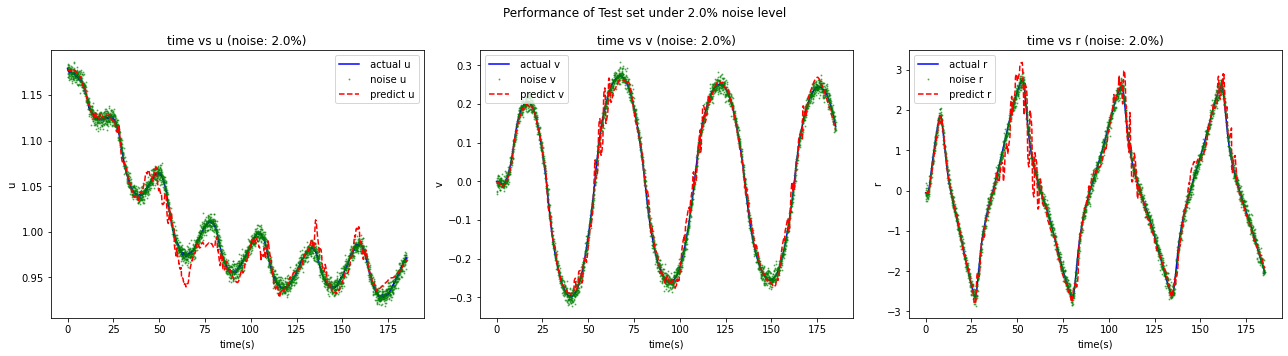


测试噪声水平: 3.0%
Noise level under 3.0% :
MSE: [0.00012136 0.0003494  0.05667844]
RMSE: [0.01101617 0.01869227 0.23807234]
MAE: [0.00799775 0.01377595 0.16292529]
MAPE: [  0.80620164  33.013195   202.66754   ]%


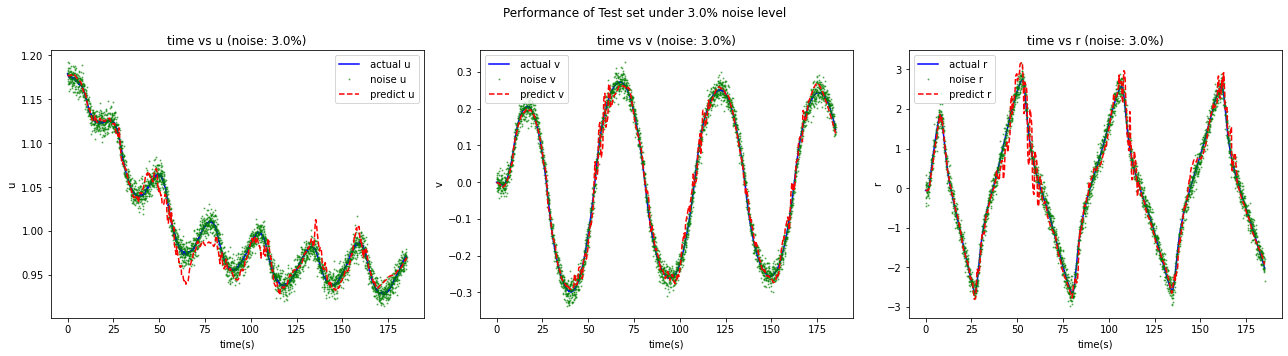


测试噪声水平: 4.0%
Noise level under 4.0% :
MSE: [0.00012136 0.0003494  0.05667844]
RMSE: [0.01101617 0.01869227 0.23807234]
MAE: [0.00799775 0.01377595 0.16292529]
MAPE: [  0.80620164  33.013195   202.66754   ]%


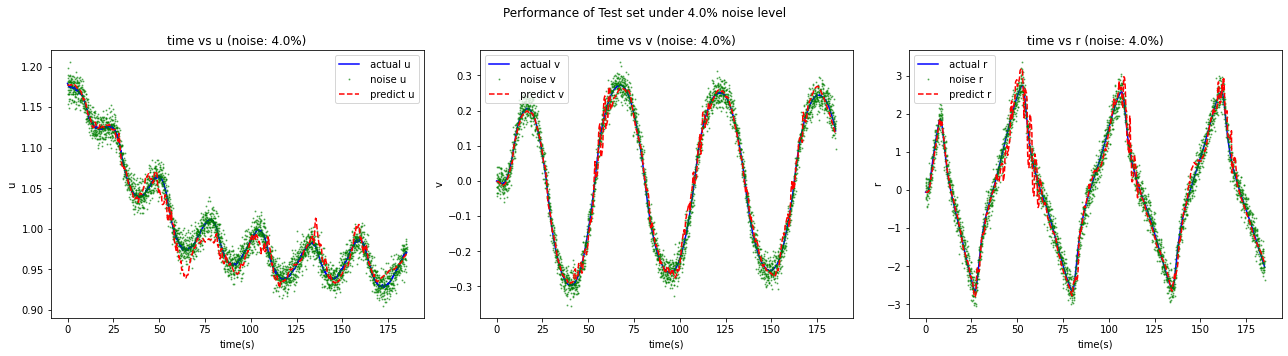


测试噪声水平: 5.0%
Noise level under 5.0% :
MSE: [0.00012136 0.0003494  0.05667844]
RMSE: [0.01101617 0.01869227 0.23807234]
MAE: [0.00799775 0.01377595 0.16292529]
MAPE: [  0.80620164  33.013195   202.66754   ]%


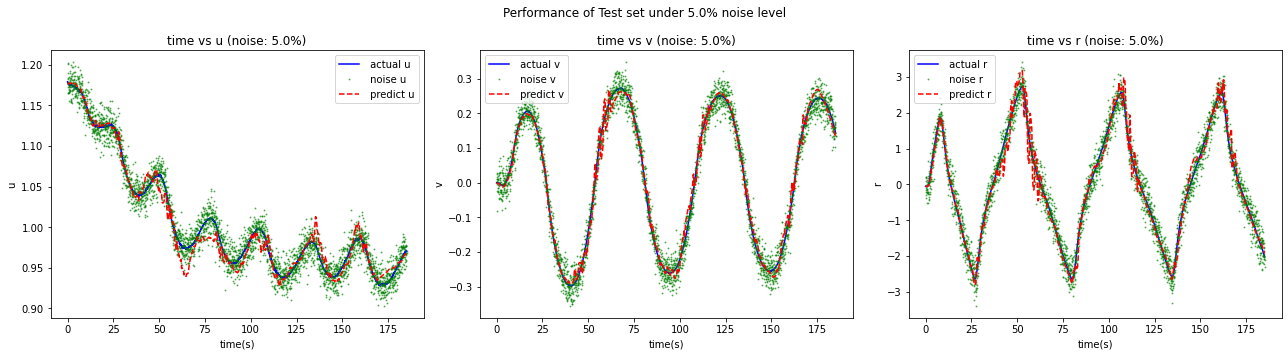

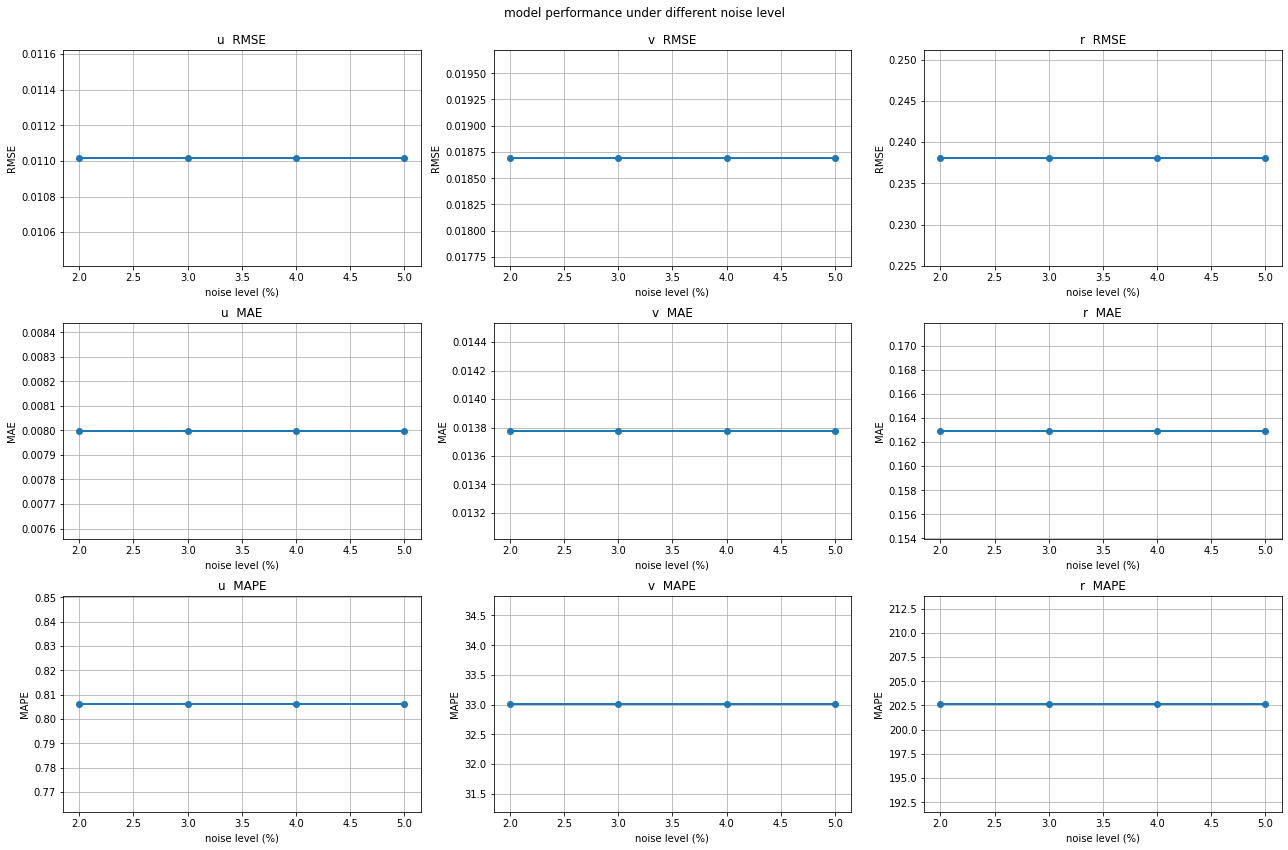

In [8]:
def test_model_with_noise(model, X_test, ship_states_test, state_scaler, noise_levels=[0.02, 0.03, 0.04, 0.05]):
    """
    测试模型在不同噪声水平下的表现
    
    Args:
        model: 训练好的PINN模型
        X_test: 测试集输入特征
        ship_states_test: 测试集实际状态值
        state_scaler: 状态标准化器
        noise_levels: 噪声水平列表（占信号幅值的百分比）
    
    Returns:
        dict: 不同噪声水平下的误差指标
    """
    model.eval()
    results = {}
    
    # 获取原始状态值（未缩放）
    original_states = state_scaler.inverse_transform(ship_states_test.numpy())
    
    # 计算信号幅值（用于确定噪声强度）
    signal_amplitudes = torch.tensor([
        torch.max(ship_states_test[:, i]) - torch.min(ship_states_test[:, i])
        for i in range(ship_states_test.shape[1])
    ])
    
    for noise_level in noise_levels:
        print(f"\n测试噪声水平: {noise_level*100}%")
        
        # 为每个状态变量生成不同的噪声
        noise = torch.zeros_like(ship_states_test)
        for i in range(ship_states_test.shape[1]):
            noise[:, i] = torch.normal(
                mean=0, 
                std=noise_level * signal_amplitudes[i], 
                size=ship_states_test[:, i].shape
            )
        
        # 添加噪声到标准化的测试数据
        noisy_states_test = ship_states_test + noise
        
        # 混合输入中的状态信息（假设前7列是输入特征）
        noisy_X_test = X_test.clone()
        
        # 前向传播预测
        with torch.no_grad():
            states_pred = model(noisy_X_test)
            
        # 反归一化预测结果和噪声数据
        states_pred_original = state_scaler.inverse_transform(states_pred.numpy())
        noisy_states_original = state_scaler.inverse_transform(noisy_states_test.numpy())
        
        # 计算指标
        mse = np.mean((states_pred_original - original_states) ** 2, axis=0)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(states_pred_original - original_states), axis=0)
        
        # 计算相对误差（MAPE: Mean Absolute Percentage Error）
        # 避免除以零
        epsilon = 1e-10
        mape = np.mean(np.abs((original_states - states_pred_original) / (np.abs(original_states) + epsilon)), axis=0) * 100
        
        # 存储结果
        results[noise_level] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'states_pred': states_pred_original,
            'noisy_states': noisy_states_original
        }
        
        # 打印结果
        print(f"Noise level under {noise_level*100}% :")
        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"MAPE: {mape}%")
        
        # 绘制噪声水平下的预测结果
        plot_prediction_with_noise(
            original_states, 
            noisy_states_original, 
            states_pred_original, 
            test_data['time'].values,
            noise_level
        )
    
    return results

def plot_prediction_with_noise(original_states, noisy_states, predicted_states, time_values, noise_level):
    """
    绘制在特定噪声水平下的预测结果
    
    Args:
        original_states: 原始状态值
        noisy_states: 添加噪声后的状态值
        predicted_states: 模型预测的状态值
        time_values: 时间序列
        noise_level: 噪声水平
    """
    state_names = ['u', 'v', 'r']
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Performance of Test set under {noise_level*100}% noise level')
    
    # 确保数据长度一致
    min_len = min(len(original_states), len(noisy_states), len(predicted_states), len(time_values))
    time_plot = time_values[:min_len]
    
    for j in range(3):
        axs[j].plot(time_plot, original_states[:min_len, j], 'b-', label=f' actual {state_names[j]}')
        axs[j].plot(time_plot, noisy_states[:min_len, j], 'g.', markersize=2, alpha=0.5, label=f' noise {state_names[j]}')
        axs[j].plot(time_plot, predicted_states[:min_len, j], 'r--', label=f' predict {state_names[j]}')
        axs[j].set_title(f'time vs {state_names[j]} (noise: {noise_level*100}%)')
        axs[j].set_xlabel('time(s)')
        axs[j].set_ylabel(state_names[j])
        axs[j].legend()
    
    plt.tight_layout()
    plt.show()

# 执行噪声测试
noise_test_results = test_model_with_noise(
    model,
    X_test,
    torch.tensor(ship_states_test_scaled, dtype=torch.float32),
    state_scaler,
    noise_levels=[0.02, 0.03, 0.04, 0.05]
)

# 绘制不同噪声水平下的性能比较图
def plot_noise_performance_comparison(noise_test_results):
    """绘制不同噪声水平下的性能比较图"""
    noise_levels = list(noise_test_results.keys())
    metrics = ['RMSE', 'MAE', 'MAPE']
    state_names = ['u', 'v', 'r']
    
    fig, axs = plt.subplots(len(metrics), 3, figsize=(18, 12))
    fig.suptitle('model performance under different noise level')
    
    for i, metric in enumerate(metrics):
        for j, state in enumerate(state_names):
            values = [noise_test_results[nl][metric][j] for nl in noise_levels]
            axs[i, j].plot(np.array(noise_levels)*100, values, 'o-', linewidth=2)
            axs[i, j].set_title(f'{state}  {metric}')
            axs[i, j].set_xlabel('noise level (%)')
            axs[i, j].set_ylabel(metric)
            axs[i, j].grid(True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

# 绘制噪声性能比较图
plot_noise_performance_comparison(noise_test_results)